In [1]:
import numpy as np
from astropy.table import Table,Column
from astropy.io import fits
import matplotlib.pyplot as plt
import bz2
import pdb
import warnings
import os.path
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from astropy import wcs
import Image
import ImageOps


In [2]:
#Edmonds cutouts
bands=['u','g','r','i','z']
e_cutouts={}
for band in bands:
    e_cutouts[band]=fits.open('587737825142440094_'+band+'_cutout_noskysub.fit')

In [3]:
gal = Table.read('Edmond_gal.fit')

In [4]:
gal

<Table masked=True length=1>
      objid         rowc_r  colc_r field ...      ra         dec     redshift
      int64        float32 float32 int16 ...   float64     float64   float64 
------------------ ------- ------- ----- ... ------------ ---------- --------
587737825142440094 1198.69 341.229   173 ... 130.06461722 56.0485093  0.02616

In [32]:
bands = ['u','g','r','i','z']
field = str(gal['field'][0])
camcol = str(gal['camcol'][0])
run = str(gal['run'][0])
rerun = str(gal['rerun'][0])

#dr7
hdulist={}
for band in bands:
    hduname = 'fpC-00'+run+'-'+band+camcol+'-0'+field+'.fit'
    hdulist[band]= fits.open(hduname)

In [51]:
def makecutouts(gal,hdulists):
    
    bands = ['u','g','r','i','z']
    cutout_images = {}
    ra = gal['ra']
    dec = gal['dec']
    for band in bands:
        
        hdulist = hdulists[band]
    
        img = hdulist[0].data
        hdr = hdulist[0].header
    
        rad = gal['petror90_r']/0.396 #[pixels] #set sized based on r band radius
        w = wcs.WCS(hdulist[0].header)
        pix = w.wcs_world2pix(ra, dec,1)
        row, col = int(pix[1]), int(pix[0])
    
        #size = 3*radius
        extents = [int(row-2*rad),int(row+2*rad), int(col-2*rad), int(col+2*rad)] 

        # otherwise, create the stamp!
        cutout = img[extents[0]:extents[1], extents[2]:extents[3]]
            # if size*Rp doesn't work, default is 3*Rp 

        # convert the array into a FITS image
        cutout_images[band] = fits.ImageHDU(data=cutout, header=hdr)

    return cutout_images

In [52]:
cutouts = makecutouts(gal,hdulist)

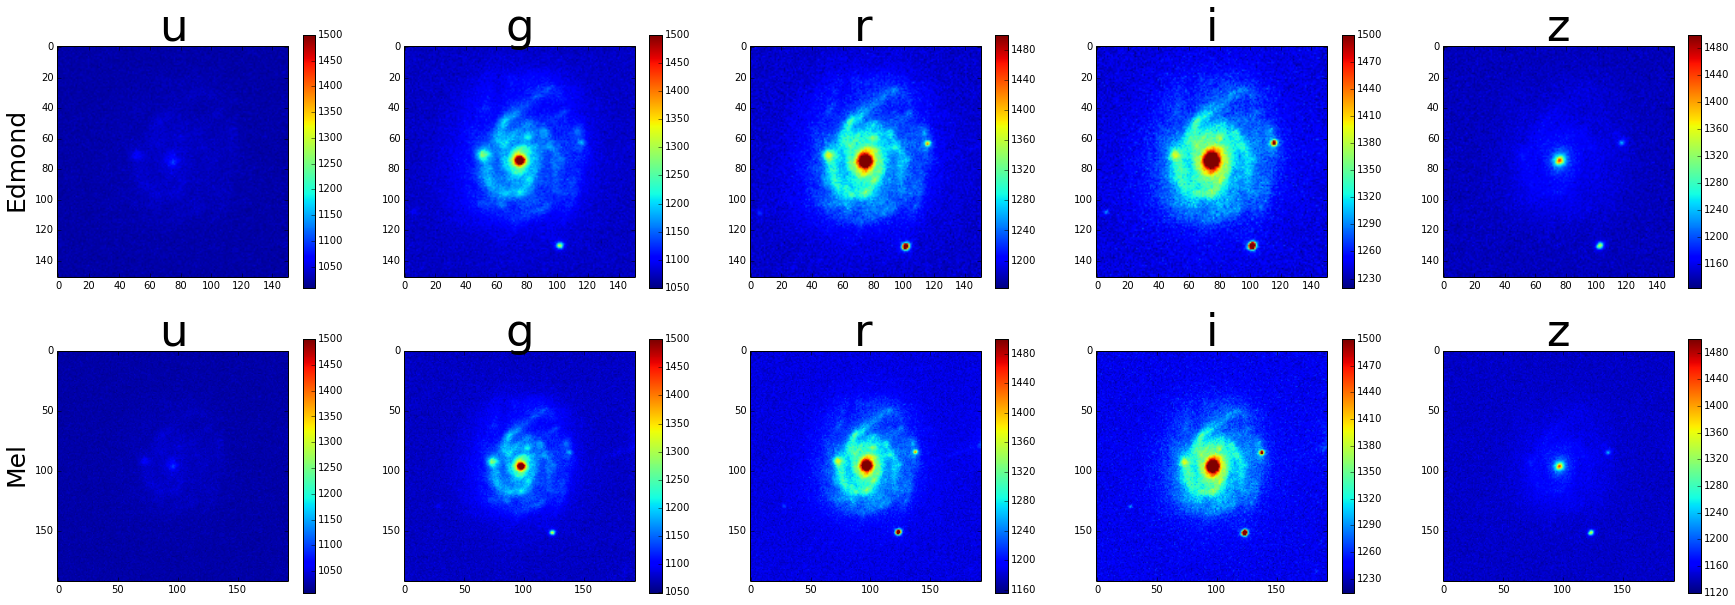

In [59]:
f = plt.figure(figsize=(30,10))
gs = gridspec.GridSpec(2,5)
for i in range(0,5):
    ax = plt.subplot(gs[0,i])
    plt.imshow(e_cutouts[bands[i]][0].data,vmax=1500)
    plt.title('%s'%bands[i],fontsize=45)
    plt.colorbar()
    if i==0:
        plt.ylabel('Edmond',fontsize=25)
for i in range(0,5):
    ax = plt.subplot(gs[1,i])
    plt.imshow(cutouts[bands[i]].data,vmax=1500)
    plt.title('%s'%bands[i],fontsize=45)
    plt.colorbar()
    if i==0:
        plt.ylabel('Mel',fontsize=25)

In [80]:
for band in bands:
    this_hdulist = hdulist[band]
    
    img = this_hdulist[0].data
    hdr = this_hdulist[0].header
    
    w = wcs.WCS(hdr)
    pix = w.wcs_world2pix(gal['ra'], gal['dec'],1)
    row, col = pix[1], pix[0]
    print band, row, col

u [ 1203.13541054] [ 343.27318982]
g [ 1209.54458324] [ 341.79862765]
r [ 1199.07314737] [ 341.60316737]
i [ 1202.7974741] [ 339.8532508]
z [ 1206.54439382] [ 340.37433027]


In [60]:
for band in cutouts:
    name = 'fits_image_'+band+'.fits'
    cutouts[band].writeto(name,clobber=True)

## Check output


In [5]:
e_imout_I = fits.open('output/587737825142440094_imout_acsf814_ugriz_z1.000_evo1.0.fits')
e_imout_V = fits.open('output/587737825142440094_imout_acsf606_ugriz_z1.000_evo1.0.fits')

## Test 1: Edmond's cutouts, using only psf with lowest fwhm, sdss row/cols for psf (1202.355, 339.4869)

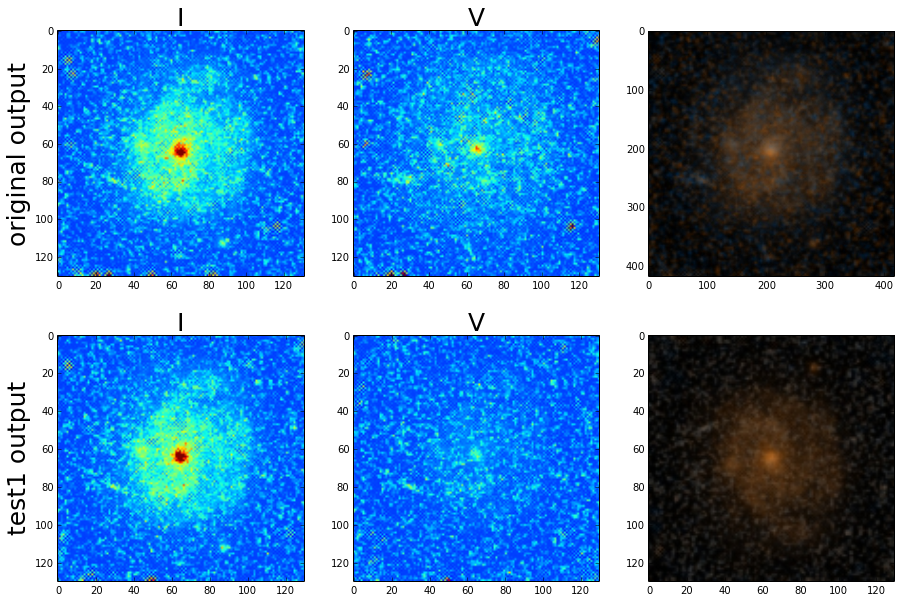

In [107]:
#Edmond's cutouts, old imerr, new psf (using only i psf for psflo)
t1_imout_I = fits.open('output/edmond_imout_I_test1.fits')
t1_imout_V = fits.open('output/edmond_imout_V_test1.fits')

f = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,3)

vmax = .03
vmin = -.007

ax = plt.subplot(gs[0,0])
plt.imshow(e_imout_I[0].data,vmax = vmax,vmin=vmin)
plt.title('I',fontsize=25)
plt.ylabel('original output',fontsize=25)

ax = plt.subplot(gs[0,1])
plt.imshow(e_imout_V[0].data,vmax = vmax,vmin=vmin)
plt.title('V',fontsize=25)

ax = plt.subplot(gs[0,2])

plt.imshow(Image.open('/home/mel/Downloads/old_image.png'))

ax = plt.subplot(gs[1,0])
plt.imshow(t1_imout_I[0].data,vmax = vmax,vmin=vmin)
plt.title('I',fontsize=25)
plt.ylabel('test1 output',fontsize=25)


ax = plt.subplot(gs[1,1])
plt.imshow(t1_imout_V[0].data,vmax = vmax,vmin=vmin)
plt.title('V',fontsize=25)

ax = plt.subplot(gs[1,2])
plt.imshow(Image.open('output/edmond_image_test1_2.jpg'))


## Test 2: Edmond's cutouts, using only psf with lowest fwhm, wcs points for row,col (1202.7974741] [ 339.8532508])

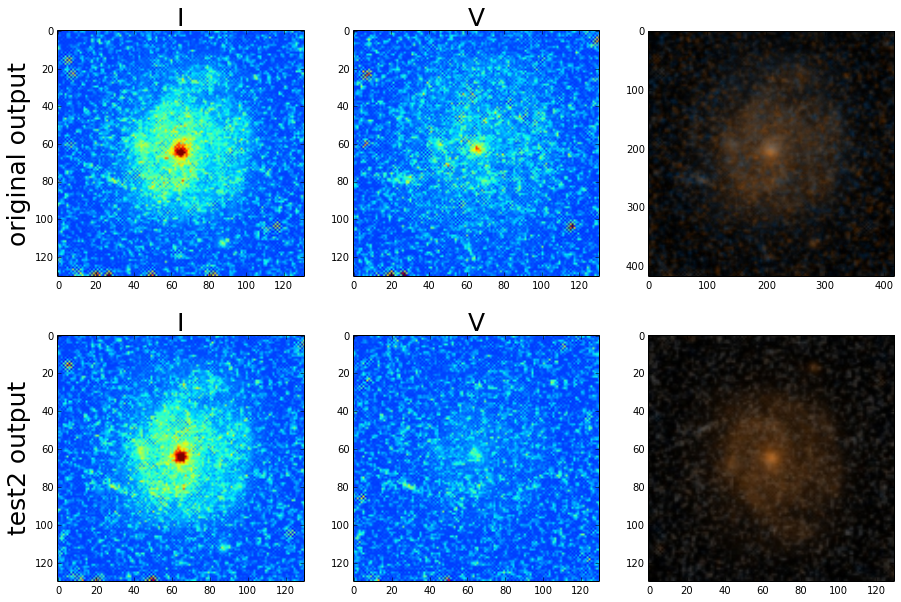

In [106]:
t2_imout_I = fits.open('output/edmond_imout_I_test2.fits')
t2_imout_V = fits.open('output/edmond_imout_V_test2.fits')

f = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,3)

vmax = .03
vmin = -.007

ax = plt.subplot(gs[0,0])
plt.imshow(e_imout_I[0].data,vmax = vmax,vmin=vmin)
plt.title('I',fontsize=25)
plt.ylabel('original output',fontsize=25)

ax = plt.subplot(gs[0,1])
plt.imshow(e_imout_V[0].data,vmax = vmax,vmin=vmin)
plt.title('V',fontsize=25)

ax = plt.subplot(gs[0,2])

plt.imshow(Image.open('/home/mel/Downloads/old_image.png'))

ax = plt.subplot(gs[1,0])
plt.imshow(t2_imout_I[0].data,vmax = vmax,vmin=vmin)
plt.title('I',fontsize=25)
plt.ylabel('test2 output',fontsize=25)


ax = plt.subplot(gs[1,1])
plt.imshow(t2_imout_V[0].data,vmax = vmax,vmin=vmin)
plt.title('V',fontsize=25)

ax = plt.subplot(gs[1,2])
plt.imshow(Image.open('output/edmond_image_test2.jpg'))


## Test 3: Edmond's cutouts, using only psf with lowest fwhm, new method for imerr

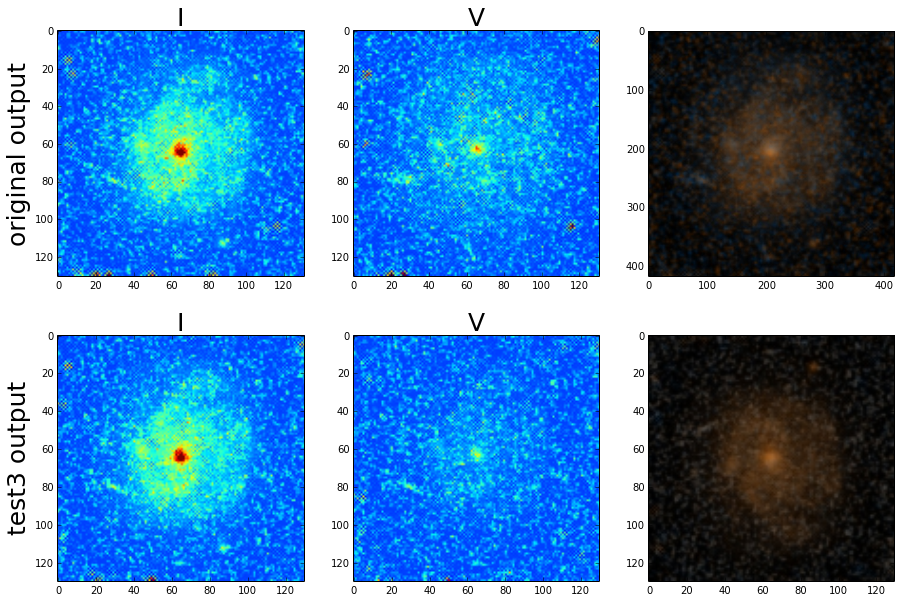

In [109]:
t3_imout_I = fits.open('output/edmond_imout_I_test3.fits')
t3_imout_V = fits.open('output/edmond_imout_V_test3.fits')

f = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,3)

vmax = .03
vmin = -.007
ax = plt.subplot(gs[0,0])
plt.imshow(e_imout_I[0].data,vmax = vmax,vmin = vmin)
plt.title('I',fontsize=25)
plt.ylabel('original output',fontsize=25)

ax = plt.subplot(gs[0,1])
plt.imshow(e_imout_V[0].data,vmax = vmax,vmin=vmin)
plt.title('V',fontsize=25)

ax = plt.subplot(gs[0,2])

plt.imshow(Image.open('/home/mel/Downloads/old_image.png'))

ax = plt.subplot(gs[1,0])
plt.imshow(t3_imout_I[0].data,vmax = vmax,vmin=vmin)
plt.title('I',fontsize=25)
plt.ylabel('test3 output',fontsize=25)


ax = plt.subplot(gs[1,1])
plt.imshow(t3_imout_V[0].data,vmax = vmax,vmin=vmin)
plt.title('V',fontsize=25)

ax = plt.subplot(gs[1,2])
plt.imshow(Image.open('output/edmond_image_test3.jpg'))
plt.savefig('test3.pdf')

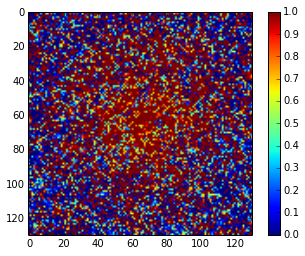

In [144]:
plt.imshow(rat,vmax=1,vmin=0)
plt.colorbar()
rat = arr/t3_imout_V[0].data

## Test 4: Trying old spiral galaxy with updates

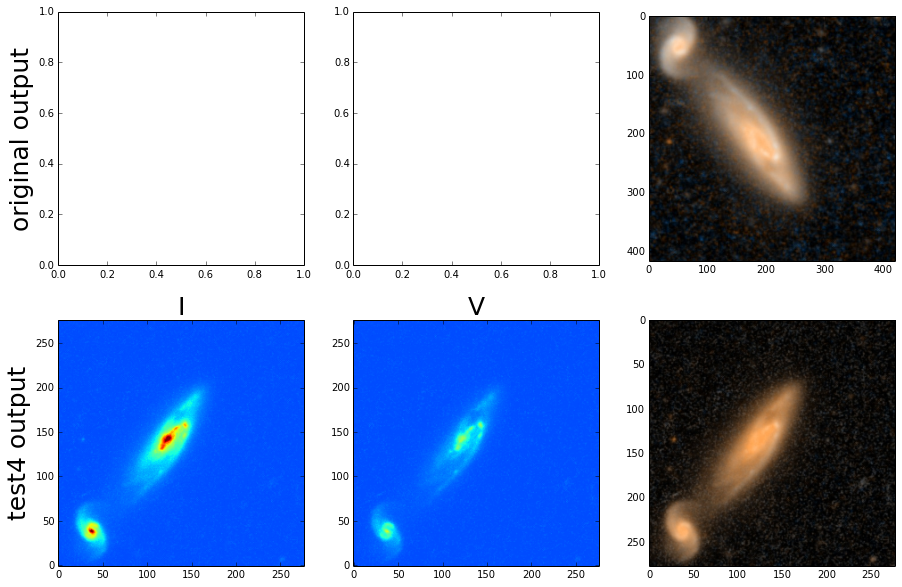

In [23]:
t4_imout_I = fits.open('../../test_old_ferengi/imout_I_dr7_test4.fits')
t4_imout_V = fits.open('../../test_old_ferengi/imout_V_dr7_test4.fits')

f = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2,3)

vmax = .4
vmin = -.1
ax = plt.subplot(gs[0,0])
plt.ylabel('original output',fontsize=25)
ax = plt.subplot(gs[0,1])

ax = plt.subplot(gs[0,2])

plt.imshow(Image.open('/home/mel/Desktop/cheung_ferengi.png'))

ax = plt.subplot(gs[1,0])
plt.imshow(t4_imout_I[0].data,vmax = vmax,vmin=vmin,origin='lower')
plt.title('I',fontsize=25)
plt.ylabel('test4 output',fontsize=25)


ax = plt.subplot(gs[1,1])
plt.imshow(t4_imout_V[0].data,vmax = vmax,vmin=vmin,origin='lower')
plt.title('V',fontsize=25)

ax = plt.subplot(gs[1,2])
plt.imshow(Image.open('../../test_old_ferengi/image_dr7_test4.jpg'))
plt.savefig('test4.pdf')